In [17]:
%load_ext autoreload
%autoreload 2

# ignore imputation warnings from pymc
# ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
import warnings
from pymc import ImputationWarning

warnings.filterwarnings("ignore", category=ImputationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
from birdcall_distribution.data import prepare_dataframe
import pandas as pd

taxonomy_df = pd.read_csv(
    "https://storage.googleapis.com/birdclef-eda-f22/data/raw/birdclef-2022/eBird_Taxonomy_v2021.csv"
)
taxonomy_df.columns = taxonomy_df.columns.str.lower()
species_mapper = taxonomy_df.set_index("species_code")["primary_com_name"].to_dict()

In [20]:
prep_df, W = prepare_dataframe(
    "../data/ee_v3_western_us_2.parquet",
    "../data/raw/birdclef-2022/train_metadata.csv",
    n_species=None,
)
df = prep_df[prep_df.primary_label == "calqua"]

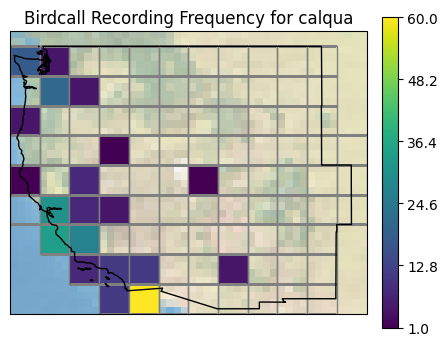

In [21]:
import matplotlib.pyplot as plt
from birdcall_distribution.plot import plot_species

plot_species(prep_df, "calqua", prop="y")
plt.show()

In [22]:
from birdcall_distribution import model
import pymc as pm
import arviz as az

m1 = model.make_pooled_intercept_car_model(df, W)
with m1:
    trace1 = pm.sample(2500, tune=1000, cores=16, target_accept=0.9)

Multiprocess sampling (16 chains in 16 jobs)
CompoundStep
>NUTS: [alpha, sigma_phi, phi, intercept]
>Metropolis: [y_missing]


Sampling 16 chains for 1_000 tune and 2_500 draw iterations (16_000 + 40_000 draws total) took 115 seconds.


Sampling: [y_observed]


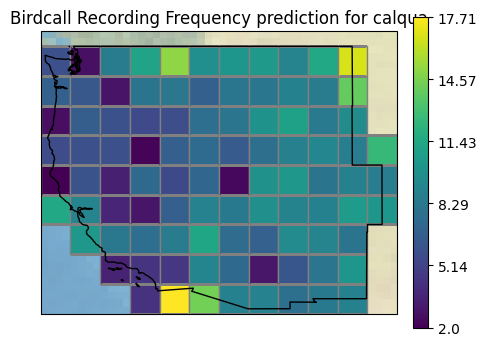

In [24]:
from birdcall_distribution.plot import plot_ppc_species

with m1:
    # posterior predictive
    ppc1 = pm.sample_posterior_predictive(trace1)

plot_ppc_species(df, ppc1, "calqua", prop="pred")
plt.show()

In [50]:
import numpy as np

with pm.Model() as m2:
    adj_idx = pm.ConstantData("adj_idx", df.index.values)

    alpha = pm.Uniform("alpha", 0, 1)
    tau = pm.Gamma("tau", 0.1, 0.1)
    phi = pm.CAR("phi", mu=np.zeros(W.shape[0]), tau=tau, alpha=alpha, W=W)
    intercept = pm.Normal("intercept", mu=0, tau=1e-4)
    mu = pm.Deterministic("mu", pm.math.exp(intercept + phi[adj_idx]))
    pm.Poisson("y", mu=mu, observed=np.ma.masked_invalid(df.y.values))

In [51]:
with m2:
    trace2 = pm.sample(2500, tune=1000, cores=16, target_accept=0.9)

Multiprocess sampling (16 chains in 16 jobs)
CompoundStep
>NUTS: [alpha, tau, phi, intercept]
>Metropolis: [y_missing]


Sampling 16 chains for 1_000 tune and 2_500 draw iterations (16_000 + 40_000 draws total) took 114 seconds.


In [53]:
az.summary(trace2, var_names=["alpha", "tau", "intercept"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.455,0.287,0.000,0.920,0.025,0.020,134.0,276.0,1.08
tau,0.232,0.112,0.078,0.429,0.013,0.009,54.0,144.0,1.21
intercept,1.574,0.290,1.049,2.099,0.028,0.020,96.0,243.0,1.11


Sampling: [y_observed]


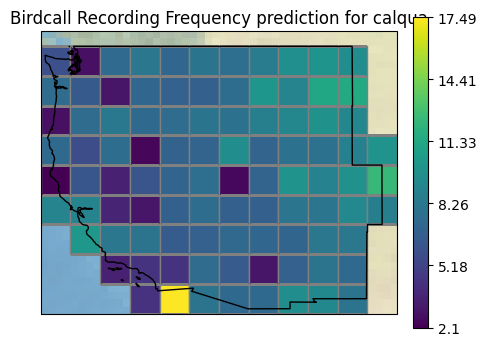

In [52]:
with m2:
    ppc2 = pm.sample_posterior_predictive(trace2)
plot_ppc_species(df, ppc2, "calqua", prop="pred")
plt.show()

In [54]:
with pm.Model() as m3:
    adj_idx = pm.ConstantData("adj_idx", df.index.values)

    alpha = pm.Beta("alpha", 5, 1)
    tau = pm.Gamma("tau", 0.1, 0.1)
    phi = pm.CAR("phi", mu=np.zeros(W.shape[0]), tau=tau, alpha=alpha, W=W)
    intercept = pm.Normal("intercept", mu=0, tau=1e-4)
    mu = pm.Deterministic("mu", pm.math.exp(intercept + phi[adj_idx]))
    pm.Poisson("y", mu=mu, observed=np.ma.masked_invalid(df.y.values))

with m3:
    trace3 = pm.sample(2500, tune=1000, cores=16, target_accept=0.9)
    ppc3 = pm.sample_posterior_predictive(trace3)

Multiprocess sampling (16 chains in 16 jobs)
CompoundStep
>NUTS: [alpha, tau, phi, intercept]
>Metropolis: [y_missing]


Sampling 16 chains for 1_000 tune and 2_500 draw iterations (16_000 + 40_000 draws total) took 112 seconds.
Sampling: [y_observed]


In [56]:
az.summary(trace3, var_names=["alpha", "tau", "intercept"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.776,0.159,0.489,1.000,0.010,0.007,248.0,1517.0,1.04
tau,0.240,0.118,0.077,0.443,0.015,0.011,52.0,207.0,1.22
intercept,1.541,0.380,0.847,2.164,0.030,0.021,131.0,440.0,1.08


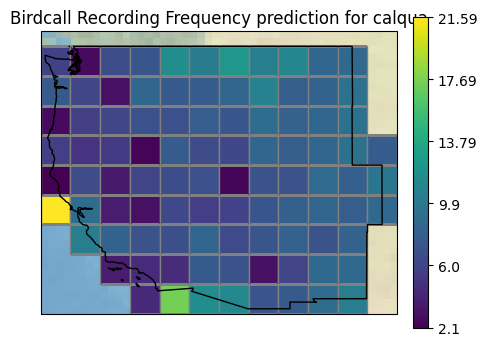

In [55]:
plot_ppc_species(df, ppc3, "calqua", prop="pred")
plt.show()

In [57]:
with pm.Model() as m4:
    adj_idx = pm.ConstantData("adj_idx", df.index.values)

    alpha = pm.Beta("alpha", 1, 5)
    tau = pm.Gamma("tau", 0.1, 0.1)
    phi = pm.CAR("phi", mu=np.zeros(W.shape[0]), tau=tau, alpha=alpha, W=W)
    intercept = pm.Normal("intercept", mu=0, tau=1e-4)
    mu = pm.Deterministic("mu", pm.math.exp(intercept + phi[adj_idx]))
    pm.Poisson("y", mu=mu, observed=np.ma.masked_invalid(df.y.values))

with m4:
    trace4 = pm.sample(2500, tune=1000, cores=16, target_accept=0.9)
    ppc4 = pm.sample_posterior_predictive(trace4)

Multiprocess sampling (16 chains in 16 jobs)
CompoundStep
>NUTS: [alpha, tau, phi, intercept]
>Metropolis: [y_missing]


Sampling 16 chains for 1_000 tune and 2_500 draw iterations (16_000 + 40_000 draws total) took 115 seconds.
Sampling: [y_observed]


In [58]:
az.summary(trace4, var_names=["alpha", "tau", "intercept"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.162,0.137,0.000,0.420,0.003,0.002,4799.0,7568.0,1.01
tau,0.217,0.104,0.074,0.402,0.014,0.010,49.0,183.0,1.23
intercept,1.562,0.246,1.091,2.013,0.036,0.026,48.0,103.0,1.24


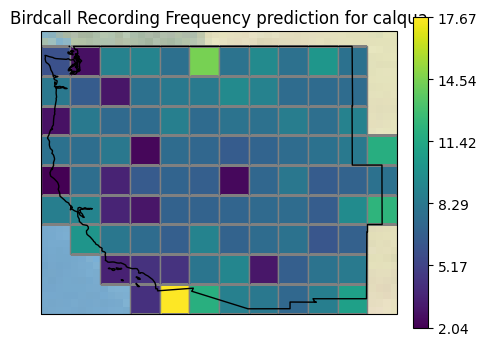

In [59]:
plot_ppc_species(df, ppc4, "calqua", prop="pred")
plt.show()

In [70]:
observed.mask.astype(int)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 0])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [alpha, tau, phi, intercept, a, b]


Sampling 16 chains for 1_000 tune and 1_000 draw iterations (16_000 + 16_000 draws total) took 92 seconds.
Sampling: [missing, y]


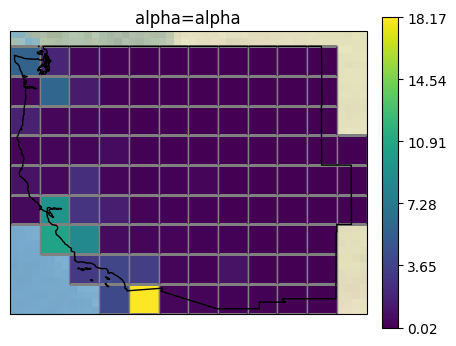

In [72]:
with pm.Model() as m:
    adj_idx = pm.ConstantData("adj_idx", df.index.values)
    alpha = pm.Beta("alpha", 5, 1)
    tau = pm.Gamma("tau", 0.1, 0.1)
    phi = pm.CAR("phi", mu=np.zeros(W.shape[0]), tau=tau, alpha=alpha, W=W)
    intercept = pm.Normal("intercept", mu=0, tau=1e-4)
    mu = pm.Deterministic("mu", pm.math.exp(intercept + phi[adj_idx]))
    observed = np.ma.masked_invalid(df.y.values)
    y_imputed = pm.Poisson("y", mu=mu, observed=observed.filled(0))
    # missingness is proportional to the imputed value
    a = pm.Normal("a", mu=0, tau=1e-3)
    b = pm.Normal("b", mu=0, tau=1e-3)
    p = pm.math.invlogit(a + b * pm.math.log(y_imputed + 1))
    pm.Bernoulli("missing", p=p, observed=observed.mask.astype(int))
    trace = pm.sample(1000, tune=1000, cores=16, target_accept=0.9)
    ppc = pm.sample_posterior_predictive(trace)
plot_ppc_species(df, ppc, "calqua", prop="pred", title=f"alpha={alpha}")
plt.show()

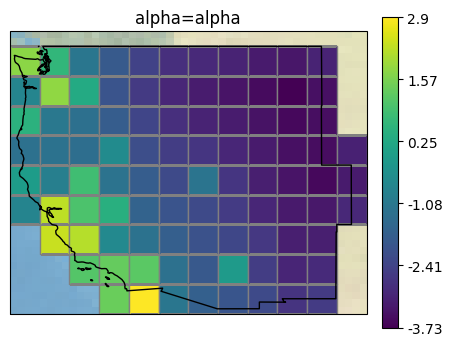

In [73]:
plot_ppc_species(df, ppc, "calqua", prop="log_pred", title=f"alpha={alpha}")
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [alpha, tau, phi, intercept]


Sampling 16 chains for 1_000 tune and 1_000 draw iterations (16_000 + 16_000 draws total) took 84 seconds.
Sampling: [y]


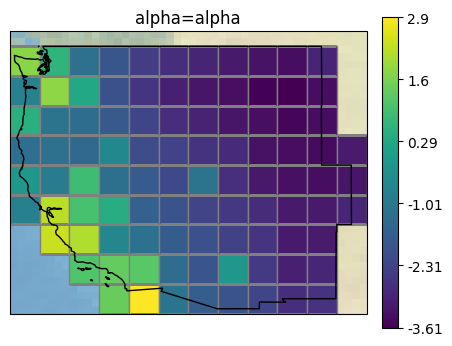

In [74]:
with pm.Model() as m:
    adj_idx = pm.ConstantData("adj_idx", df.index.values)
    alpha = pm.Beta("alpha", 5, 1)
    tau = pm.Gamma("tau", 0.1, 0.1)
    phi = pm.CAR("phi", mu=np.zeros(W.shape[0]), tau=tau, alpha=alpha, W=W)
    intercept = pm.Normal("intercept", mu=0, tau=1e-4)
    mu = pm.Deterministic("mu", pm.math.exp(intercept + phi[adj_idx]))
    observed = np.ma.masked_invalid(df.y.values)
    y_imputed = pm.Poisson("y", mu=mu, observed=observed.filled(0))
    trace = pm.sample(1000, tune=1000, cores=16, target_accept=0.9)
    ppc = pm.sample_posterior_predictive(trace)
plot_ppc_species(df, ppc, "calqua", prop="log_pred", title=f"alpha={alpha}")
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [tau, phi, intercept]


Sampling 16 chains for 1_000 tune and 1_000 draw iterations (16_000 + 16_000 draws total) took 83 seconds.
Sampling: [y]


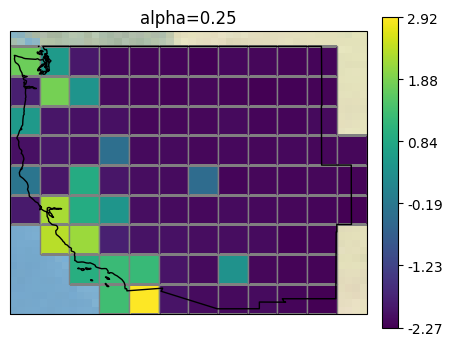

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [tau, phi, intercept]


Sampling 16 chains for 1_000 tune and 1_000 draw iterations (16_000 + 16_000 draws total) took 82 seconds.
Sampling: [y]


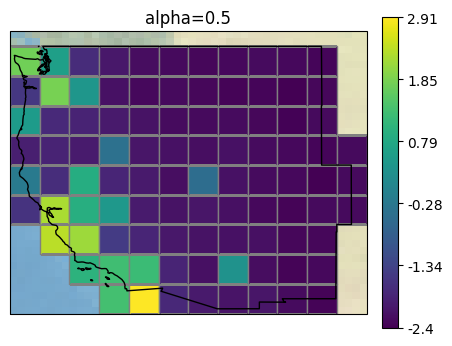

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [tau, phi, intercept]


Sampling 16 chains for 1_000 tune and 1_000 draw iterations (16_000 + 16_000 draws total) took 82 seconds.
Sampling: [y]


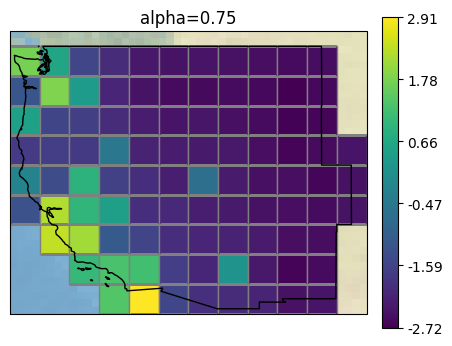

In [76]:
alphas = [0.25, 0.5, 0.75]
traces = []
ppcs = []
for alpha in alphas:
    with pm.Model() as m:
        adj_idx = pm.ConstantData("adj_idx", df.index.values)
        tau = pm.Gamma("tau", 0.1, 0.1)
        phi = pm.CAR("phi", mu=np.zeros(W.shape[0]), tau=tau, alpha=alpha, W=W)
        intercept = pm.Normal("intercept", mu=0, tau=1e-4)
        mu = pm.Deterministic("mu", pm.math.exp(intercept + phi[adj_idx]))
        pm.Poisson("y", mu=mu, observed=np.ma.masked_invalid(df.y.values).filled(0))
        trace = pm.sample(1000, tune=1000, cores=16, target_accept=0.9)
        ppc = pm.sample_posterior_predictive(trace)
    traces.append(trace)
    ppcs.append(ppc)
    plot_ppc_species(df, ppc, "calqua", prop="log_pred", title=f"alpha={alpha}")
    plt.show()